# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_year_date_str_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260109.xlsx"
code = "7011"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_year_date_str_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/0109
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 60
PERIOD_MA_2 : 600
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 7.5
LOSSCUT_1 : -25


In [3]:
# 取引明細
df_transaction = app.getTransaction()
print("取引明細")
list_html = conv_transaction_df2html(df_transaction)
filename = os.path.join("output", f"{date_str}_{code}_transaction.html")
print(filename)
with open(filename, mode="w") as f:
    f.write("\n".join(list_html))

print(df_transaction)
list_trans = [pd.to_datetime(t) for t in df_transaction["注文日時"]]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
output/2026/0109_7011_transaction.html
   注文番号                 注文日時 銘柄コード  売買  約定単価 約定数量    損益 備考
0     1  2026-01-09 09:24:47  7011  売建  4249  100   NaN   
1     2  2026-01-09 09:25:48  7011  買埋  4249  100     0   
2     3  2026-01-09 09:45:41  7011  買建  4258  100   NaN   
3     4  2026-01-09 09:46:45  7011  売埋  4249  100  -900   
4     5  2026-01-09 10:15:57  7011  買建  4230  100   NaN   
5     6  2026-01-09 10:25:49  7011  売埋  4228  100  -200   
6     7  2026-01-09 10:25:50  7011  売建  4228  100   NaN   
7     8  2026-01-09 10:33:34  7011  買埋  4227  100   100   
8     9  2026-01-09 10:53:35  7011  買建  4213  100   NaN   
9    10  2026-01-09 11:07:07  7011  売埋  4223  100  1000   
10   11  2026-01-09 11:13:21  7011  売建  4223  100   NaN   
11   12  2026-01-09 11:14:20  7011  買埋  4225  100  -200   
12   13  2026-01-09 11:27:33  7011  買建  4232  100   NaN   
13   14  2026-01-09 12:31:26  7011  売埋  4231  100  -100   
14   15  2026-01-09 12:42:29  7011  買建  4228  100   NaN   
15   16  202

In [4]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price          ma1          ma2    slope1  \
2026-01-09 09:00:02  1.767917e+09   4201  4201.000000  4201.000000  0.000000   
2026-01-09 09:00:03  1.767917e+09   4201  4201.000000  4201.000000  0.000000   
2026-01-09 09:00:04  1.767917e+09   4212  4204.666667  4204.666667  2.200000   
2026-01-09 09:00:05  1.767917e+09   4212  4206.500000  4206.500000  2.095238   
2026-01-09 09:00:06  1.767917e+09   4232  4211.600000  4211.600000  3.105556   
...                           ...    ...          ...          ...       ...   
2026-01-09 15:24:45  1.767940e+09   4266  4265.866667  4262.756667  0.000000   
2026-01-09 15:24:46  1.767940e+09   4266  4265.866667  4262.756667  0.000000   
2026-01-09 15:24:47  1.767940e+09   4266  4265.866667  4262.756667  0.000000   
2026-01-09 15:24:48  1.767940e+09   4265  4265.866667  4262.755000  0.000000   
2026-01-09 15:24:49  1.767940e+09   4265  4265.866667  4262.753333  0.000000   

                     rr  profit

In [5]:
df_tech["slope1"].describe()

count    19427.000000
mean         0.042052
std          0.076438
min          0.000000
25%          0.013333
50%          0.027222
75%          0.050000
max          3.580000
Name: slope1, dtype: float64

In [6]:
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

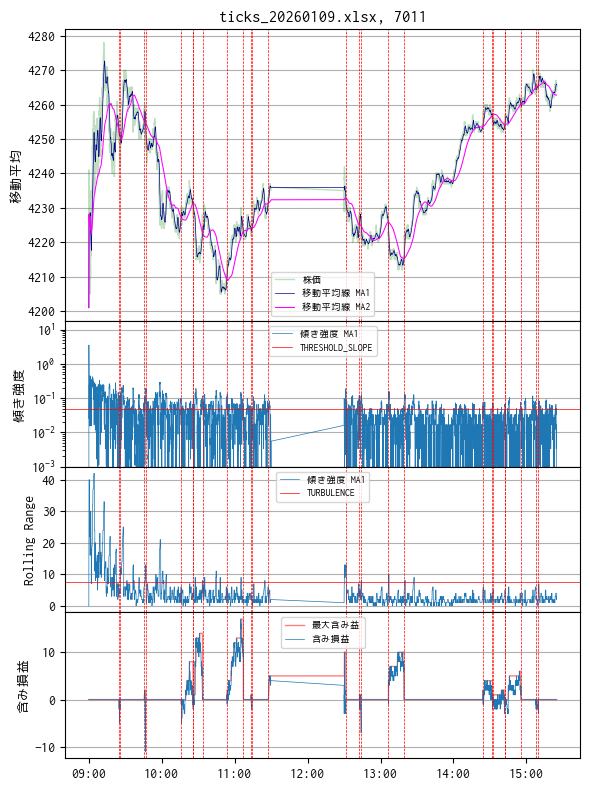

In [7]:
fig = plt.figure(figsize=(6, 8))
n = 4
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)
_, y_high = ax[1].get_ylim()
ax[1].set_ylim(0.001, y_high)

ax[2].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[2].set_ylabel("Rolling Range")
ax[2].legend(fontsize=7)

ax[3].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[3].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[3].set_ylabel("含み損益")
ax[3].legend(fontsize=7)

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
#output = os.path.join("output", f"{date_str}_{code}_trend_technical.png")
output = os.path.join("tmp", f"{date_str}_{code}_trend_technical.png")
plt.tight_layout()
plt.savefig(output)
plt.show()

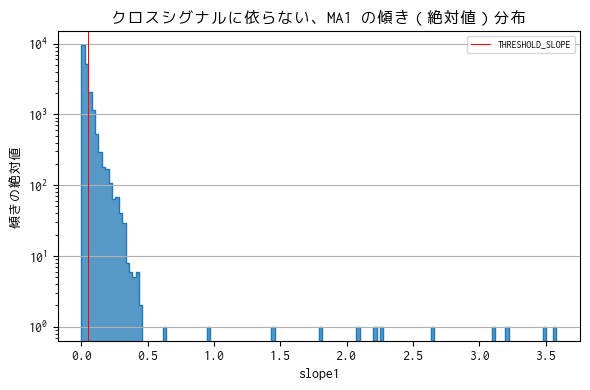

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("クロスシグナルに依らない、MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
#output = os.path.join("output", f"{date_str}_{code}_trend_technical.png")
output = os.path.join("tmp", f"{date_str}_{code}_hist_slope.png")
plt.savefig(output)
plt.show()

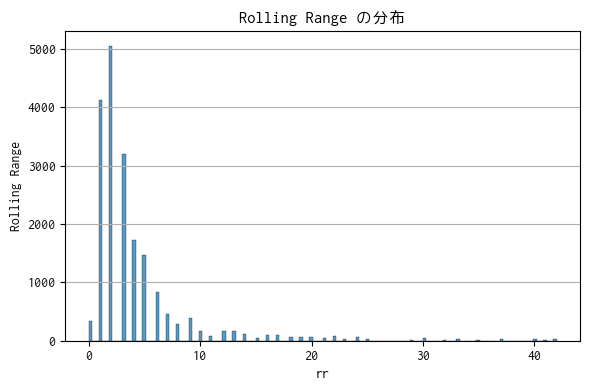

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
#ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
#ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
#ax.legend(fontsize=7)

plt.tight_layout()
#output = os.path.join("output", f"{date_str}_{code}_trend_technical.png")
output = os.path.join("tmp", f"{date_str}_{code}_hist_rr.png")
plt.savefig(output)
plt.show()

In [10]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1   建玉
2026-01-09 09:00:02    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 09:00:03    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 09:00:04    0.0    0.0  0.0  1.0  0.0  0.0
2026-01-09 09:00:05    0.0    0.0  0.0  1.0  0.0  0.0
2026-01-09 09:00:06    0.0    0.0  0.0  1.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...
2026-01-09 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0
2026-01-09 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0

[19427 rows x 6 columns]


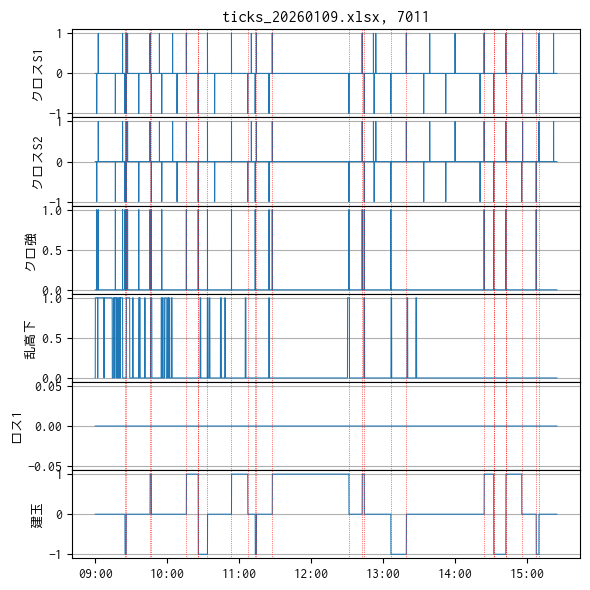

In [11]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=[1 for i in range(n)])
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

for i, colname in enumerate(df_obs.columns):
    ax[i].plot(df_obs[colname], linewidth=0.75)
    ax[i].set_ylabel(colname)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
#output = os.path.join("output", f"{date_str}_{code}_trend_obs.png")
output = os.path.join("tmp", f"{date_str}_{code}_trend_obs.png")
plt.tight_layout()
plt.savefig(output)
plt.show()